In [1]:
import datetime
now = datetime.datetime.now()

# Probability Calibration

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [2]:
print(now.strftime("%Y-%m-%d"))

2021-09-24


In [3]:
# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()

In [4]:
# Plot calibration plots
def plot():
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (gnb, 'Naive Bayes'),
                      (svc, 'Support Vector Classification'),
                      (rfc, 'Random Forest')]:
        clf.fit(X_train, y_train)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2);

[scikit-learn](https://scikit-learn.org/stable/modules/calibration.html), [Niculescu-Mizil and Caruana (2005)](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430?casa_token=lWF4J7WXaLgAAAAA:ocm4dF1Vzn5q1-nlatrEzfiGfvyNq0ZIfiDM1NhU5r1Sv-4N9toiIRH7BgkTnR3fhKosg1CjGxNUDxg)

# Well-calibrated classifiers
* For probabilistic classifiers, the output can be directly interpreted as a confidence level. 
* Example: A classifier should classify the samples such that among the samples to which it assigned a predicted probability value close to 0.8, approx. 80% actually belong to the positive class.
* A logistic regression returns well-calibrated predictions as it directly optimizes log-loss.

# Not so well-calibrated classifiers

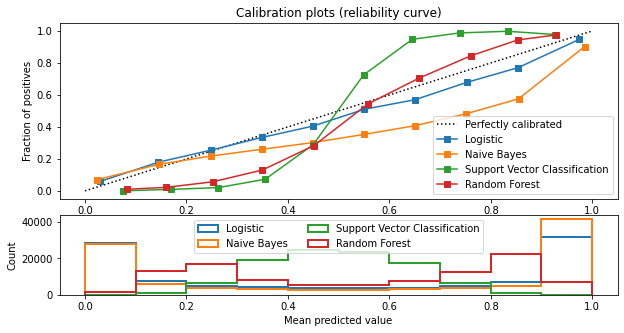

In [5]:
plot()

* `GaussianNaiveBayes`
   * Tends to push probabilities to 0 or 1.
   * It assumes that features are conditionally independent given the class.
   * This is not the case in this dataset (containing 2 redundant features).
   
```python
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)
```

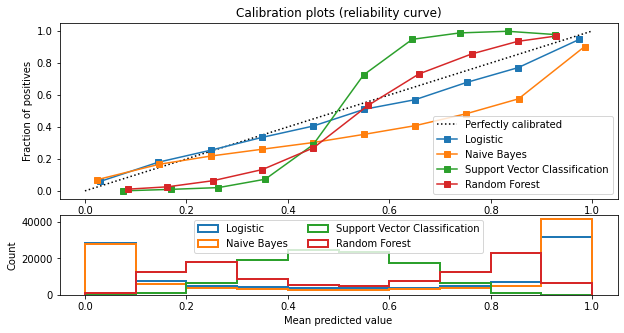

In [6]:
plot()

* `RandomForestClassifier`
   * Peaks at approx. 0.2 and 0.9 probability.
   * Probabilities close to 0 or 1 are very rare. 
   * [Niculescu-Mizil and Caruana (2005)](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430?casa_token=lWF4J7WXaLgAAAAA:ocm4dF1Vzn5q1-nlatrEzfiGfvyNq0ZIfiDM1NhU5r1Sv-4N9toiIRH7BgkTnR3fhKosg1CjGxNUDxg) provide more details.
   * The calibration curve shows a characteristic sigmoid shape. 

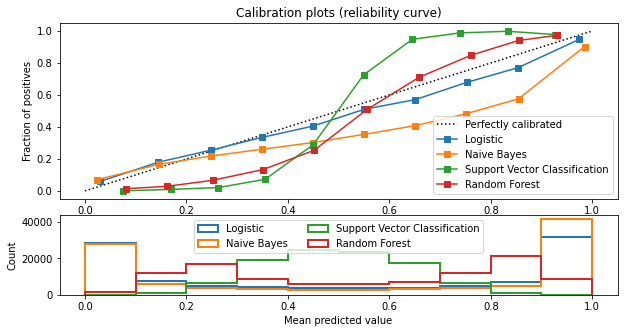

In [7]:
plot()

* Support Vector Classification (SVC)
    * SVC shows an even more sigmoid curve as the random forest classifier. 
    * This is typical for maximum-margin methods, which focus on hard samples that are close to the decision boundary (the support vectors).

# How it works
[scikit-learn](https://scikit-learn.org/stable/modules/calibration.html)

* Calibrating consists of fitting a calibrator that maps the output of the classifier to a calibrated probability in $[0, 1]$. 
* $f_{i}$ denotes the output of the classifier for a given sample.
* The calibrator tries to predict $p(y_i=1|f_i)$.
* The samples used to fit the calibrator should not be the same used to fit the classifier (bias!).

# Use it

* The [CalibratedClassifierCV class](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV) is used to calibrate a classifier.
* It supports the use of two regressors: "sigmoid" and "isotonic".

🤓: Use `CalibratedClassifierCV` to train and calibrate a classifier of your choice. Plot it.